# GME Closing Price Time Series Forecast

In [1]:
import pandas as pd

In [2]:
### If you are using colab, you can import google drive to save model checkpoints in a folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
gme = pd.read_csv("./drive/MyDrive/GameStop Analysis/GME.csv")

In [4]:
gme.shape

(1258, 7)

In [5]:
gme.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
1248,2024-01-30,14.54,14.82,14.51,14.55,14.55,1652600
1249,2024-01-31,14.40,14.83,14.22,14.23,14.23,2684700
1250,2024-02-01,14.34,14.42,14.02,14.42,14.42,2220200
1251,2024-02-02,14.15,14.92,14.08,14.73,14.73,2922600
1252,2024-02-05,14.50,14.61,13.40,13.46,13.46,4361500
1253,2024-02-06,13.60,14.30,13.43,14.10,14.10,3047800
1254,2024-02-07,14.12,14.30,13.78,14.07,14.07,1947800
1255,2024-02-08,14.01,14.44,13.89,14.35,14.35,1838300
1256,2024-02-09,14.37,15.23,14.30,14.66,14.66,3571600
1257,2024-02-12,14.58,15.22,14.53,14.73,14.73,2747500


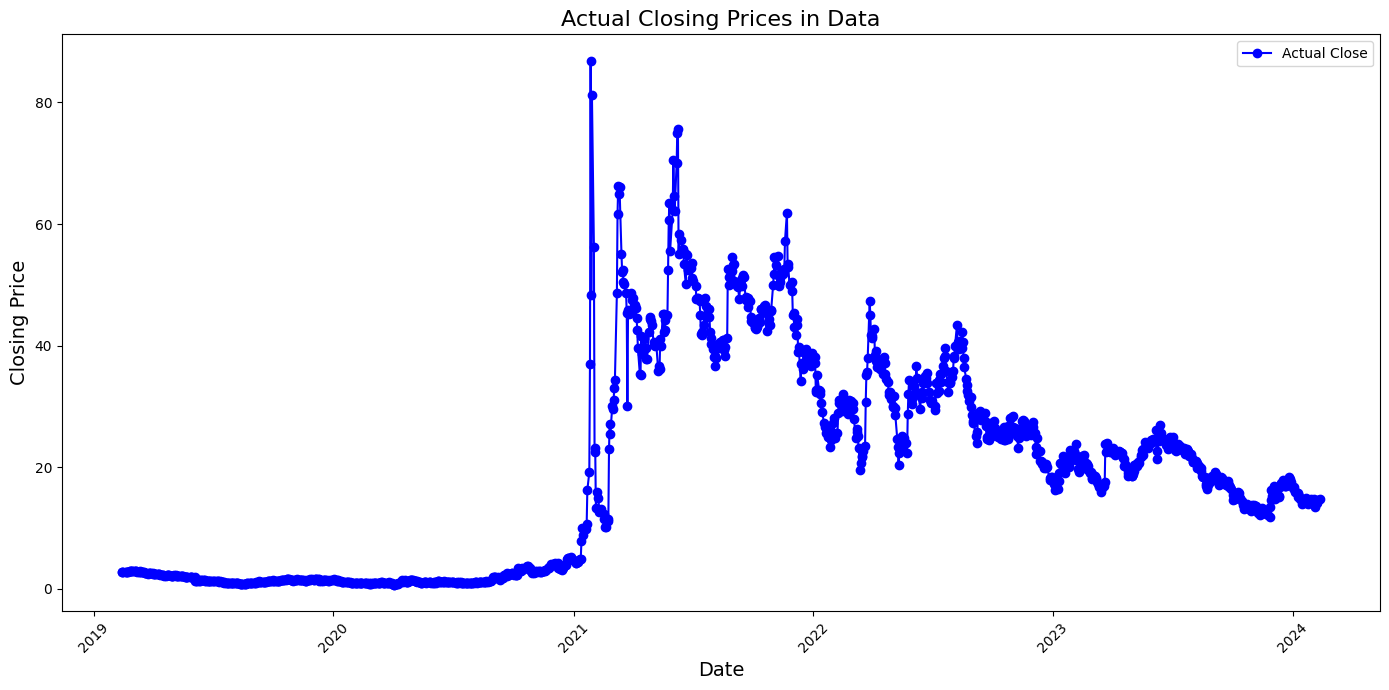

In [6]:
import matplotlib.pyplot as plt


# Ensure the 'Date' column is in datetime format for proper plotting
gme['Date'] = pd.to_datetime(gme['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(gme['Date'], gme['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

In [8]:
# Convert 'Date' to datetime and sort the DataFrame just in case
gme['Date'] = pd.to_datetime(gme['Date']) # This line converts the 'Date' column of the DataFrame df to datetime objects.
gme.sort_values('Date', inplace=True)
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 1) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = gme['Close'].values.reshape(-1, 1)
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [9]:
scaled_close_prices.shape

(1258, 1)

In [10]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [11]:
SEQUENCE_LENGTH = 20  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)

In [12]:
print(X.shape)
print(y.shape)

(1238, 20, 1)
(1238, 1)


In [13]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = gme[gme['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

In [14]:
print(X_train.shape, y_train.shape)

torch.Size([557, 20, 1]) torch.Size([557, 1])


In [15]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

## Pytorch LSTM

In [16]:
import torch
import torch.nn as nn

class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(StockPriceLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define LSTM layer with batch_first=True
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Define output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Dynamically adjust batch size based on input
        batch_size = input_seq.size(0)

        # Initialize hidden and cell states with dynamic batch size
        hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device),
                       torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device))

        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(input_seq, hidden_cell)

        # Only take the output from the final time step
        lstm_out = lstm_out[:, -1, :]

        # Forward pass through the linear layer
        predictions = self.linear(lstm_out)
        return predictions


In [17]:
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
model = StockPriceLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 32

# Create the dataset
stock_dataset = StockDataset(X_train, y_train)

# Create the DataLoader
train_loader = DataLoader(dataset=stock_dataset, batch_size=batch_size, shuffle=True)


In [19]:
epochs = 150

for epoch in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()

        # Resetting the hidden state is important for stateful LSTMs;
        # for stateless (which is often default), it's not strictly necessary.
        model.hidden_cell = (torch.zeros(1, batch_size, model.hidden_layer_size),
                             torch.zeros(1, batch_size, model.hidden_layer_size))

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')


Epoch 0 Loss: 0.009994106367230415
Epoch 25 Loss: 0.001957871951162815
Epoch 50 Loss: 0.0009384897421114147
Epoch 75 Loss: 0.00014870654558762908
Epoch 100 Loss: 0.0004854646685998887
Epoch 125 Loss: 5.773533848696388e-05


In [20]:
# Assuming `X_train` is your input tensor with shape (n_samples, seq_length, n_features)
# and `model` is your trained LSTM model

# Step 1: Extract the last sequence from X_train
last_sequence = X_train[-1:]  # Shape: (1, seq_length, n_features)

# Initialize a list to hold the predictions
predictions = []

# Step 2: Predict the next 66 days
for _ in range(len(business_days)):
    with torch.no_grad():  # Ensure we're in inference mode (no gradients needed)
        model.eval()  # Set the model to evaluation mode
        # Predict the next value
        prediction = model(last_sequence)
        # Store the prediction
        predictions.append(prediction.item())
        # Update the sequence with the new prediction
        new_sequence = torch.cat((last_sequence[:, 1:, :], prediction.view(1, 1, 1)), dim=1)
        last_sequence = new_sequence

# Inverse transform
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predictions.reshape(-1)
})

# Show the prediction results
print(predictions_df)

         Date  Predicted_Close
0  2021-06-01        58.574462
1  2021-06-02        59.903038
2  2021-06-03        56.464853
3  2021-06-04        52.125877
4  2021-06-07        49.877395
..        ...              ...
61 2021-08-25        50.309510
62 2021-08-26        50.309418
63 2021-08-27        50.309346
64 2021-08-30        50.309310
65 2021-08-31        50.309335

[66 rows x 2 columns]


## Visualize Prediction

In [21]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
gme['Date'] = pd.to_datetime(gme['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(gme[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        58.574462     62.255001
1  2021-06-02        59.903038     70.559998
2  2021-06-03        56.464853     64.544998
3  2021-06-04        52.125877     62.090000
4  2021-06-07        49.877395     70.002502
..        ...              ...           ...
61 2021-08-25        50.309510     49.912498
62 2021-08-26        50.309418     51.305000
63 2021-08-27        50.309346     51.237499
64 2021-08-30        50.309310     52.299999
65 2021-08-31        50.309335     54.560001

[66 rows x 3 columns]


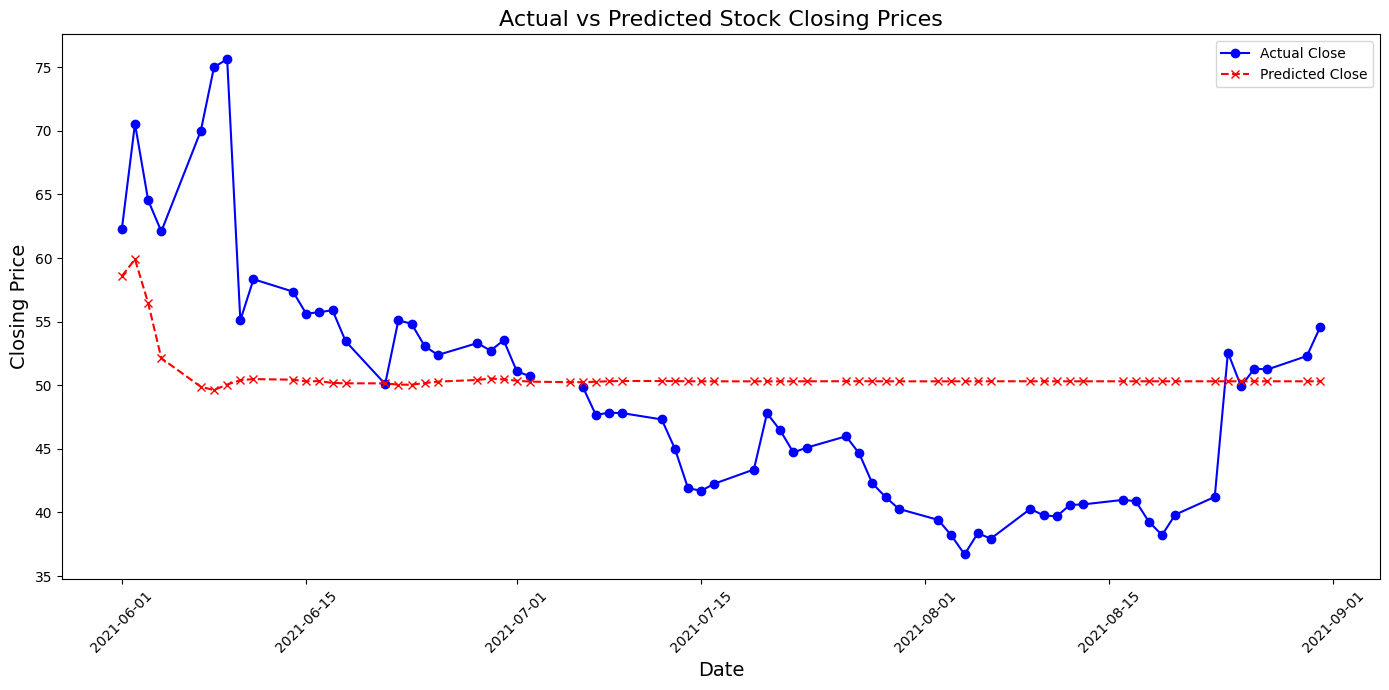

In [22]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# r/WSB Sentiment Analysis using TextBlob

In [33]:
wsb = pd.read_csv("./drive/MyDrive/GameStop Analysis/reddit_wsb.csv")
wsb.tail(10)

,title,score,id,url,comms_num,created,body,timestamp
53177,"$CRSR August 20, 2021 Unusual Options Activity 👀",200,owhamt,https://www.reddit.com/r/wallstreetbets/commen...,115,1.627919e+09,"A)50$ strike\n3,048 Open Interest\n310 Volume ...",2021-08-02 18:49:40
53178,$48K $BABA and $TX YOLO,57,owgboj,https://i.redd.it/0fce81oxlye71.jpg,17,1.627917e+09,NaN,2021-08-02 18:02:28
53179,Down 20% on PSFE (about 12k),82,owg8da,https://i.redd.it/bly9u33flye71.jpg,34,1.627916e+09,NaN,2021-08-02 17:58:12
53180,$AMD JUST GETTING STARTED 🌕🌕🚀🚀,928,owfh43,https://i.redd.it/swjl3qogeye71.jpg,283,1.627914e+09,NaN,2021-08-02 17:19:14
53181,Ten Year Price Prediction for TSLA,156,owfbxp,https://www.reddit.com/r/wallstreetbets/commen...,204,1.627913e+09,"It’s all contingent on them mastering FSD, but...",2021-08-02 17:11:36
53182,What I Learned Investigating SAVA FUD Spreaders,238,owd2pn,https://www.reddit.com/r/wallstreetbets/commen...,87,1.627906e+09,***TLDR: Three bitter scientists partnered up ...,2021-08-02 15:03:27
53183,"Daily Popular Tickers Thread for August 02, 20...",228,owd1a5,https://www.reddit.com/r/wallstreetbets/commen...,1070,1.627906e+09,\nYour daily hype thread. Please keep the shit...,2021-08-02 15:01:03
53184,Hitler reacts to the market being irrational,7398,owc5dr,https://v.redd.it/46jxu074exe71,372,1.627902e+09,NaN,2021-08-02 13:59:35
53185,"Daily Discussion Thread for August 02, 2021",338,owbfjf,https://www.reddit.com/r/wallstreetbets/commen...,11688,1.627898e+09,Your daily trading discussion thread. Please k...,2021-08-02 13:00:16
53186,Fraternal Association of Gambling Gentlemen an...,40,owaqd6,https://www.reddit.com/r/wallstreetbets/commen...,810,1.627895e+09,This is an old Yacht Club thread. Click /u/Vis...,2021-08-02 12:00:14


In [34]:
# Filter rows where the 'title' column contains 'GME'
wsb = wsb[wsb['title'].str.contains('GME', case=False)].reset_index()
wsb.tail(10)

,index,title,score,id,url,comms_num,created,body,timestamp
8634,53011,"Been on the GME train since the beginning, now...",0,oy1kdv,https://www.reddit.com/gallery/oy1kdv,15,1.628109e+09,NaN,2021-08-04 23:28:19
8635,53032,"I sold my #AMC #GME to buy #HOOD, Hood can rea...",0,oxvwl8,https://i.redd.it/xyz14jue7df71.jpg,44,1.628093e+09,NaN,2021-08-04 19:06:25
8636,53038,"GME to 500 and S&P500, let’s go baby",385,oxvbkx,https://i.redd.it/z954piol2df71.jpg,141,1.628092e+09,NaN,2021-08-04 18:39:27
8637,53061,Ford Mustang Mach-E Sales Grew 15.8 Percent in...,47,oxszue,https://www.businesswire.com/news/home/2021080...,21,1.628085e+09,NaN,2021-08-04 16:45:05
8638,53067,"Daily Popular Tickers Thread for August 04, 20...",312,oxr6fe,https://www.reddit.com/r/wallstreetbets/commen...,1421,1.628078e+09,\nYour daily hype thread. Please keep the shit...,2021-08-04 15:01:20
8639,53107,Lost 70K on GME but here’s my HOOD yolo,19,oxcpjg,https://i.redd.it/gvszmjazh7f71.jpg,104,1.628024e+09,NaN,2021-08-03 23:54:59
8640,53120,GME 20k YOLO - Going to 0 or 6 figures,3446,ox9p9b,https://i.redd.it/plfafes9s6f71.jpg,546,1.628015e+09,NaN,2021-08-03 21:31:36
8641,53143,"Daily Popular Tickers Thread for August 03, 20...",404,ox1zi7,https://www.reddit.com/r/wallstreetbets/commen...,1832,1.627992e+09,\nYour daily hype thread. Please keep the shit...,2021-08-03 15:01:02
8642,53174,GME $950 Calls YOLO (IV Dipped Under 100% agai...,2997,owihcd,https://i.redd.it/9pds8gxrxye71.jpg,530,1.627923e+09,NaN,2021-08-02 19:46:18
8643,53183,"Daily Popular Tickers Thread for August 02, 20...",228,owd1a5,https://www.reddit.com/r/wallstreetbets/commen...,1070,1.627906e+09,\nYour daily hype thread. Please keep the shit...,2021-08-02 15:01:03


In [35]:
# Group the Posts by day and concatenate all the titles
wsb['timestamp'] = pd.to_datetime(wsb['timestamp'])
grouped_df = wsb.groupby(wsb['timestamp'].dt.date)['title'].apply(lambda x: ' '.join(x)).reset_index()
print(grouped_df)

      timestamp                                              title
0    2021-01-28  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
1    2021-01-29  Current data on GME short positions WHATS THIS...
2    2021-01-30  DEGIRO ONLY ALLOWING LIMIT ORDERS FOR GME AND ...
3    2021-01-31  What can I do to support GME as someone who’s ...
4    2021-02-01  although they write that Melvin is down 53% th...
..          ...                                                ...
149  2021-08-04  Been on the GME train since the beginning, now...
150  2021-08-05  I heard GME YOLOs were cool again Daily Popula...
151  2021-08-09  Daily Popular Tickers Thread for August 09, 20...
152  2021-08-11  GROW: the same guy who discovered GME in June ...
153  2021-08-12                          Made $25,000 shorting GME

[154 rows x 2 columns]


In [36]:
# Noticed that on some days there are not posts about GME on r/WSB
# We place a dummy str on days without posts
# To locate the actual dates we are interested in (that have closing prices)
# We join the two tables
# We choose to only include closing prices after 2021-01-28
TRAIN_START_DATE = "2021-01-28"

dummy_title_df = pd.DataFrame({
    'timestamp': gme["Date"],
    'title': "No GME posts on this date"
})

# Keep only relevant time frame
dummy_title_df = dummy_title_df[dummy_title_df['timestamp'] >= "2021-01-28"]
dummy_title_df = dummy_title_df[dummy_title_df['timestamp'] <= "2021-08-12"]
dummy_title_df['timestamp'] = pd.to_datetime(dummy_title_df['timestamp']).dt.date

# CONCAT
combined_df = pd.concat([grouped_df, dummy_title_df])

# Removing duplicates based on 'timestamp' to keep original titles
combined_df = combined_df.drop_duplicates(subset=['timestamp'], keep='first')

# Sort by timestamp to maintain chronological order
combined_df = combined_df.sort_values(by='timestamp').reset_index(drop=True)

print(combined_df)

      timestamp                                              title
0    2021-01-28  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
1    2021-01-29  Current data on GME short positions WHATS THIS...
2    2021-01-30  DEGIRO ONLY ALLOWING LIMIT ORDERS FOR GME AND ...
3    2021-01-31  What can I do to support GME as someone who’s ...
4    2021-02-01  although they write that Melvin is down 53% th...
..          ...                                                ...
175  2021-08-06                          No GME posts on this date
176  2021-08-09  Daily Popular Tickers Thread for August 09, 20...
177  2021-08-10                          No GME posts on this date
178  2021-08-11  GROW: the same guy who discovered GME in June ...
179  2021-08-12                          Made $25,000 shorting GME

[180 rows x 2 columns]


In [37]:
# Compute Sentiment Score with TextBlob
from textblob import TextBlob
import pandas as pd

# Define a function to compute sentiment polarity
def compute_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the 'title' column to create a new 'polarity' column
combined_df['polarity'] = combined_df['title'].apply(compute_polarity)

print(combined_df)

      timestamp                                              title  polarity
0    2021-01-28  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...  0.037875
1    2021-01-29  Current data on GME short positions WHATS THIS...  0.059853
2    2021-01-30  DEGIRO ONLY ALLOWING LIMIT ORDERS FOR GME AND ...  0.038738
3    2021-01-31  What can I do to support GME as someone who’s ...  0.064826
4    2021-02-01  although they write that Melvin is down 53% th...  0.058472
..          ...                                                ...       ...
175  2021-08-06                          No GME posts on this date  0.000000
176  2021-08-09  Daily Popular Tickers Thread for August 09, 20...  0.375000
177  2021-08-10                          No GME posts on this date  0.000000
178  2021-08-11  GROW: the same guy who discovered GME in June ...  0.000000
179  2021-08-12                          Made $25,000 shorting GME  0.000000

[180 rows x 3 columns]


# Fusion Model

In [38]:
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
combined_df = combined_df.merge(gme[['Date', 'Close']], left_on='timestamp', right_on='Date', how='left')

final_df = combined_df.dropna()
final_df

,timestamp,title,polarity,Date,Close
0,2021-01-28,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,0.037875,2021-01-28,48.400002
1,2021-01-29,Current data on GME short positions WHATS THIS...,0.059853,2021-01-29,81.250000
4,2021-02-01,although they write that Melvin is down 53% th...,0.058472,2021-02-01,56.250000
5,2021-02-02,"If you're buying silver, comment here! (not fo...",0.082262,2021-02-02,22.500000
6,2021-02-03,Loss porn: IM NOT FUCKING SELLING. $GME 💎 🙌 💎 ...,0.074211,2021-02-03,23.102501
...,...,...,...,...,...
175,2021-08-06,No GME posts on this date,0.000000,2021-08-06,37.942501
176,2021-08-09,"Daily Popular Tickers Thread for August 09, 20...",0.375000,2021-08-09,40.282501
177,2021-08-10,No GME posts on this date,0.000000,2021-08-10,39.762501
178,2021-08-11,GROW: the same guy who discovered GME in June ...,0.000000,2021-08-11,39.695000


In [39]:
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 2) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = final_df[['Close', 'polarity']].values.reshape(-1, 2)
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(close_prices)

In [40]:
scaled_features.shape

(137, 2)

In [41]:
SEQUENCE_LENGTH = 20  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_features, SEQUENCE_LENGTH)
print(X.shape)
print(y.shape)

(117, 20, 2)
(117, 2)


In [42]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = final_df[final_df['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

print(X_train.shape, y_train.shape)

torch.Size([97, 20, 2]) torch.Size([97, 2])


In [43]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=53, freq='B')

In [44]:
import torch
import torch.nn as nn

class FusionLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=100, output_size=2):
        super(FusionLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define LSTM layer with batch_first=True
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Define output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Dynamically adjust batch size based on input
        batch_size = input_seq.size(0)

        # Initialize hidden and cell states with dynamic batch size
        hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device),
                       torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device))

        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(input_seq, hidden_cell)

        # Only take the output from the final time step
        lstm_out = lstm_out[:, -1, :]

        # Forward pass through the linear layer
        predictions = self.linear(lstm_out)
        return predictions


In [45]:
model = FusionLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 32

# Create the dataset
stock_dataset = StockDataset(X_train, y_train)

# Create the DataLoader
train_loader = DataLoader(dataset=stock_dataset, batch_size=batch_size, shuffle=True)

In [46]:
epochs = 150

for epoch in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()

        # Resetting the hidden state is important for stateful LSTMs;
        # for stateless (which is often default), it's not strictly necessary.
        model.hidden_cell = (torch.zeros(1, batch_size, model.hidden_layer_size),
                             torch.zeros(1, batch_size, model.hidden_layer_size))

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

Epoch 0 Loss: 0.34797459840774536
Epoch 25 Loss: 0.013382681645452976
Epoch 50 Loss: 0.058655425906181335
Epoch 75 Loss: 8.001290552783757e-05
Epoch 100 Loss: 0.04975039139389992
Epoch 125 Loss: 0.03443886339664459


In [47]:
# Assuming `X_train` is your input tensor with shape (n_samples, seq_length, n_features)
# and `model` is your trained LSTM model

# Step 1: Extract the last sequence from X_train
last_sequence = X_train[-1:]  # Shape: (1, seq_length, n_features)

# Initialize a list to hold the predictions
predictions = []

# Step 2: Predict the next 66 days
for _ in range(len(business_days)):
    with torch.no_grad():  # Ensure we're in inference mode (no gradients needed)
        model.eval()  # Set the model to evaluation mode
        # Predict the next value
        prediction = model(last_sequence)
        # Store the prediction
        predictions.append(prediction.tolist()[0])
        # Update the sequence with the new prediction
        new_sequence = torch.cat((last_sequence[:, 1:, :], prediction.view(1, 1, 2)), dim=1)
        last_sequence = new_sequence

# Inverse transform
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 2))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predictions[:, 0].reshape(-1),
    'Predicted_Sentiment': predictions[:, 1].reshape(-1)
})

# Show the prediction results
print(predictions_df)

         Date  Predicted_Close  Predicted_Sentiment
0  2021-06-01        44.897366             0.003968
1  2021-06-02        44.835711             0.000435
2  2021-06-03        44.867497            -0.001663
3  2021-06-04        44.949927            -0.002689
4  2021-06-07        45.055776            -0.003042
5  2021-06-08        45.168092            -0.003014
6  2021-06-09        45.276658            -0.002796
7  2021-06-10        45.376011            -0.002501
8  2021-06-11        45.463471            -0.002205
9  2021-06-14        45.538489            -0.001933
10 2021-06-15        45.601398            -0.001701
11 2021-06-16        45.653233            -0.001511
12 2021-06-17        45.695347            -0.001358
13 2021-06-18        45.729133            -0.001236
14 2021-06-21        45.755870            -0.001145
15 2021-06-22        45.776827            -0.001077
16 2021-06-23        45.793118            -0.001025
17 2021-06-24        45.805625            -0.000987
18 2021-06-2

In [48]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
gme['Date'] = pd.to_datetime(gme['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(gme[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Predicted_Sentiment  Actual_Close
0  2021-06-01        44.897366             0.003968     62.255001
1  2021-06-02        44.835711             0.000435     70.559998
2  2021-06-03        44.867497            -0.001663     64.544998
3  2021-06-04        44.949927            -0.002689     62.090000
4  2021-06-07        45.055776            -0.003042     70.002502
5  2021-06-08        45.168092            -0.003014     75.000000
6  2021-06-09        45.276658            -0.002796     75.639999
7  2021-06-10        45.376011            -0.002501     55.097500
8  2021-06-11        45.463471            -0.002205     58.334999
9  2021-06-14        45.538489            -0.001933     57.360001
10 2021-06-15        45.601398            -0.001701     55.625000
11 2021-06-16        45.653233            -0.001511     55.742500
12 2021-06-17        45.695347            -0.001358     55.897499
13 2021-06-18        45.729133            -0.001236     53.455002
14 2021-06

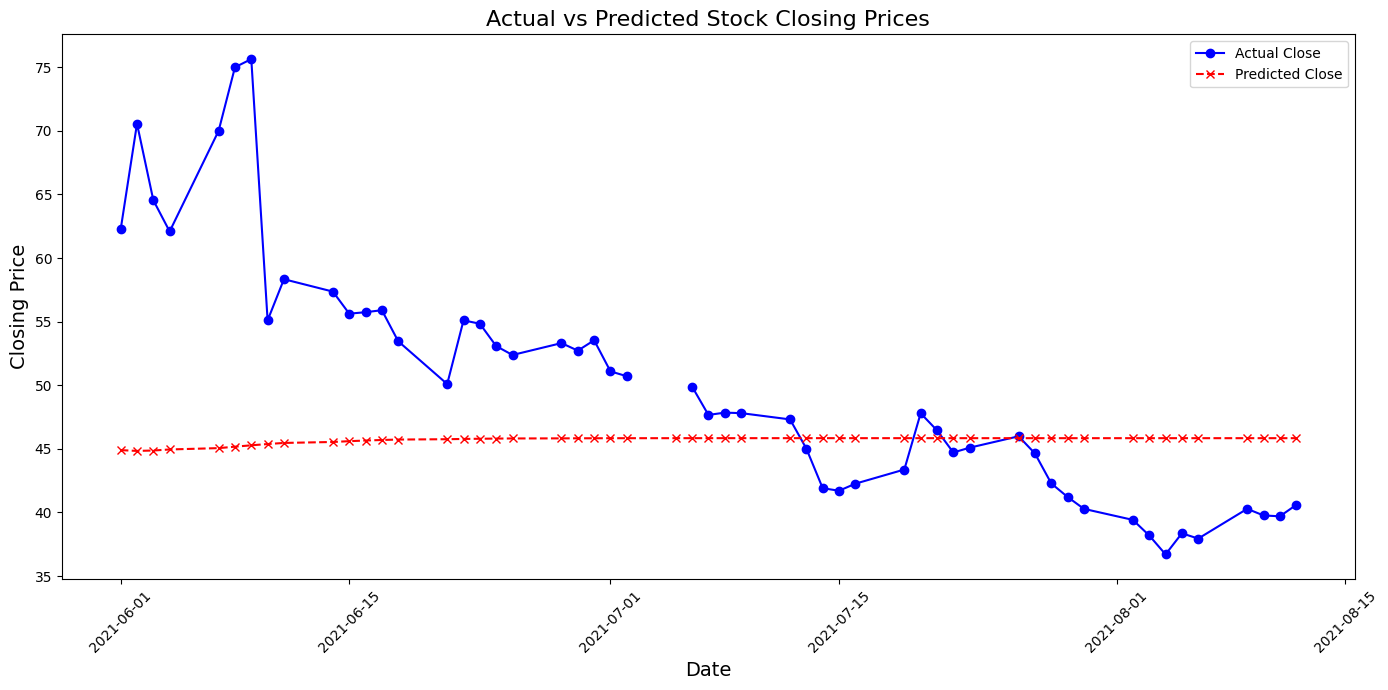

In [49]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()